In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization

keras.utils.set_random_seed(111)

**Download dataet**

In [2]:
!pip install kaggle

In [8]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [9]:
# Download Dataset
!kaggle datasets download -d vitngquang/uit-viic-v1-0-vietnamese-image-captioning

100% 1.23G/1.23G [00:56<00:00, 25.0MB/s]
100% 1.23G/1.23G [00:56<00:00, 23.3MB/s]


In [10]:
import shutil
import os

def delete_folder_and_contents(folder_path):
    try:
        # Deleting all files and subdirectories
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)
            if os.path.isfile(item_path):
                os.unlink(item_path)
            else:
                shutil.rmtree(item_path)

        # Deleting the folder itself
        shutil.rmtree(folder_path)

        print(f"{folder_path} and its contents are successfully deleted.")

    except Exception as e:
        print(f"An error occurred: {e}")

# Replace 'folder_path' with the path to the folder you want to delete
# folder_path = "/content/dataset"

# delete_folder_and_contents(folder_path)


In [11]:
!unzip /content/uit-viic-v1-0-vietnamese-image-captioning.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/images/000000534373.jpg  
  inflating: /content/dataset/train/images/000000534513.jpg  
  inflating: /content/dataset/train/images/000000534694.jpg  
  inflating: /content/dataset/train/images/000000534734.jpg  
  inflating: /content/dataset/train/images/000000534876.jpg  
  inflating: /content/dataset/train/images/000000535325.jpg  
  inflating: /content/dataset/train/images/000000535467.jpg  
  inflating: /content/dataset/train/images/000000535668.jpg  
  inflating: /content/dataset/train/images/000000536419.jpg  
  inflating: /content/dataset/train/images/000000536653.jpg  
  inflating: /content/dataset/train/images/000000537069.jpg  
  inflating: /content/dataset/train/images/000000537097.jpg  
  inflating: /content/dataset/train/images/000000537631.jpg  
  inflating: /content/dataset/train/images/000000538113.jpg  
  inflating: /content/dataset/train/images/000000538454.jpg  
  inflating: /conte

**Xử lý dataset**

In [12]:
def create_text_data(folder_path):
  text_data = []

  captions_file = f'{folder_path}/captions.txt'
  with open(captions_file, 'r', encoding='UTF-8') as file:
    lines = file.readlines()

  for line in lines:
    image_path, caption = line.strip().split('\t')[:2]
    caption = "<start> " + caption.strip() + " <end>"
    text_data.append(caption)

  return text_data


text_data = []
for folder_path in ['/content/dataset/train',
                    '/content/dataset/val',
                    '/content/dataset/test']:
                    text_data += create_text_data(folder_path)

text_data[:5]

['<start> Người đàn ông đang đánh tennis ngoài sân. <end>',
 '<start> Một vận động viên tennis đang vung vợt đánh bóng. <end>',
 '<start> Một cầu thủ tennis đang vung vợt tennis đỡ bóng. <end>',
 '<start> Người đàn ông đang đứng ngoài biên cầm vợt sẵn sàng đỡ bóng. <end>',
 '<start> Vận động viên tennis nam đang trong tư thế chuẩn bị đỡ bóng. <end>']

In [30]:
def create_caption_mapping(folder_path):
  caption_mapping = {}
  captions_file = f'{folder_path}/captions.txt'
  with open(captions_file, 'r', encoding='UTF-8') as file:
    lines = file.readlines()

  for line in lines:
    image_path, caption = line.strip().split('\t')[:2]
    caption = "<start> " + caption.strip() + " <end>"
    image_path = image_path[1:]  #----- remove "/" at beginning.
    if image_path not in caption_mapping:
      caption_mapping[image_path] = []
    caption_mapping[image_path].append(caption)


  for image_path in caption_mapping:
    if len(caption_mapping[image_path]) > 5:
      caption_mapping[image_path] = caption_mapping[image_path][:5]
    elif len(caption_mapping[image_path]) < 5:
      extra_captions = [caption_mapping[image_path][-1]] * (5 - len(caption_mapping[image_path]))
      caption_mapping[image_path] += extra_captions

  return caption_mapping


train_data = create_caption_mapping(folder_path='/content/dataset/train')
valid_data = create_caption_mapping(folder_path='/content/dataset/val')
test_data = create_caption_mapping(folder_path='/content/dataset/test')

In [31]:
train_data

{'dataset/train/images/000000157656.jpg': ['<start> Người đàn ông đang đánh tennis ngoài sân. <end>',
  '<start> Một vận động viên tennis đang vung vợt đánh bóng. <end>',
  '<start> Một cầu thủ tennis đang vung vợt tennis đỡ bóng. <end>',
  '<start> Người đàn ông đang đứng ngoài biên cầm vợt sẵn sàng đỡ bóng. <end>',
  '<start> Vận động viên tennis nam đang trong tư thế chuẩn bị đỡ bóng. <end>'],
 'dataset/train/images/000000049860.jpg': ['<start> Một màn hình máy tính trắng đang đặt trên chiếc bàn gỗ. <end>',
  '<start> Một cái bàn bừa bộn và có một quả bóng nảy màu vàng dưới đất. <end>',
  '<start> Hình ảnh một quả bóng bự bên cạnh bàn gỗ. <end>',
  '<start> Một quả bóng nảy vàng đang đặt dưới đất cạnh chiếc bàn gỗ. <end>',
  '<start> Một quả bóng yoga vàng đang đặt dưới đất cạnh chiếc bàn. <end>'],
 'dataset/train/images/000000053702.jpg': ['<start> Một người đàn ông đang chơi ném dĩa ngoài sân. <end>',
  '<start> Một số người đàn ông đang chơi ném dĩa ngoài sân. <end>',
  '<start> 

In [32]:
# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

In [33]:
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  2695
Number of validation samples:  924


**Vectorizing the text data**

In [34]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

**Building a tf.data.Dataset pipeline for training**

In [35]:
len(train_data.keys())

2695

In [36]:
len(train_data.values())

2695

In [38]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

**Building the model**

In [39]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

16705208/16705208 [==============================] - 2s 0us/step


**Model training**

In [ ]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction='auto',
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/30
43/43 [==============================] - 79s 1s/step - loss: 25.3464 - acc: 0.1280 - val_loss: 12.2937 - val_acc: 0.5259
Epoch 2/30
43/43 [==============================] - 33s 756ms/step - loss: 10.5010 - acc: 0.5492 - val_loss: 9.2296 - val_acc: 0.5991
Epoch 3/30
43/43 [==============================] - 33s 770ms/step - loss: 8.5485 - acc: 0.6087 - val_loss: 8.1048 - val_acc: 0.6288
Epoch 4/30
43/43 [==============================] - 34s 782ms/step - loss: 7.6645 - acc: 0.6363 - val_loss: 7.6733 - val_acc: 0.6356
Epoch 5/30
43/43 [==============================] - 33s 757ms/step - loss: 7.0859 - acc: 0.6522 - val_loss: 7.1885 - val_acc: 0.6572
Epoch 6/30
43/43 [==============================] - 33s 751ms/step - loss: 6.7016 - acc: 0.6661 - val_loss: 7.0691 - val_acc: 0.6623
Epoch 7/30
43/43 [==============================] - 37s 860ms/step - loss: 6.3952 - acc: 0.6724 - val_loss: 6.7783 - val_acc: 0.6697
Epoch 8/30
43/43 [==============================] - 33s 754ms/step - 

In [48]:
caption_model.save_weights("weights.h5")


# Load model

In [54]:
# Recreate the model architecture
loaded_model = ImageCaptioningModel(
    cnn_model=get_cnn_model(),
    encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1),
    decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
)
# Load the weights
loaded_model.load_weights("/content/weights.h5")

ValueError: Unable to load weights saved in HDF5 format into a subclassed Model which has not created its variables yet. Call the Model first, then load the weights.

**Check sample predictions**

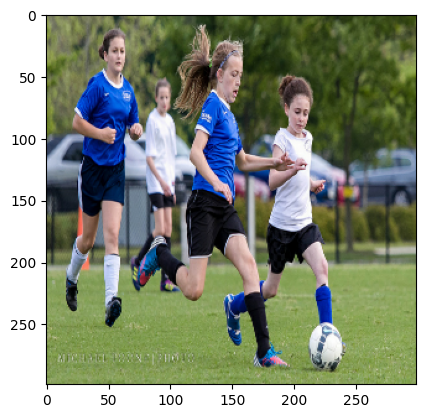

Predicted Caption:  hai cầu thủ bóng đá nữ đang tranh chấp bóng ở trên sân


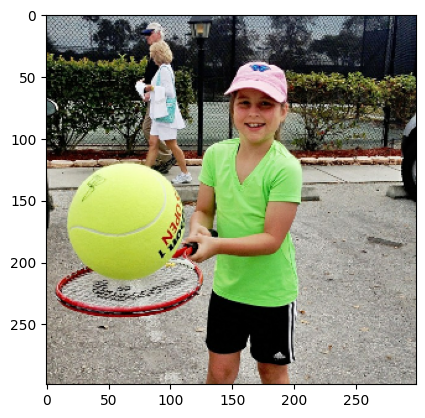

Predicted Caption:  một cô bé đang cầm vợt tennis và đứng ở trên sân


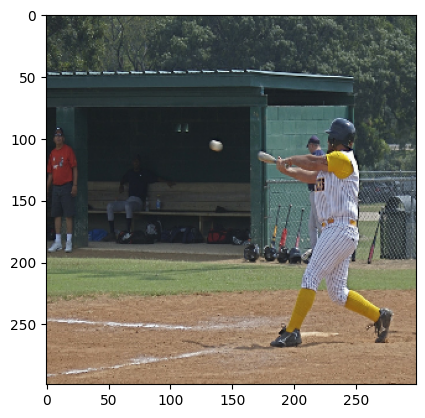

Predicted Caption:  một người đàn ông đang vung gậy để đánh quả bóng chày


In [42]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()

In [57]:
test_img = '/content/dataset/test/images/000000011015.jpg'

In [55]:
def generate_caption(sample_img):
    # Select a random image from the validation dataset
    # sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)

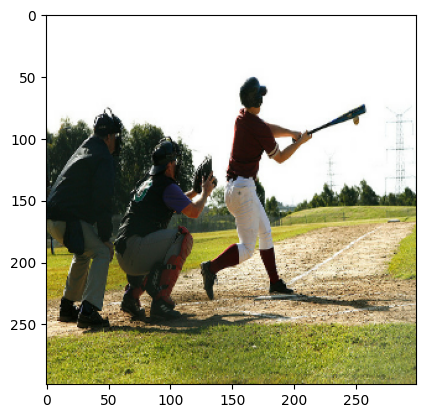

Predicted Caption:  một cầu thủ đánh bóng đang xoay người để đánh bóng


In [60]:
generate_caption(sample_img='/content/dataset/test/images/000000045554.jpg')

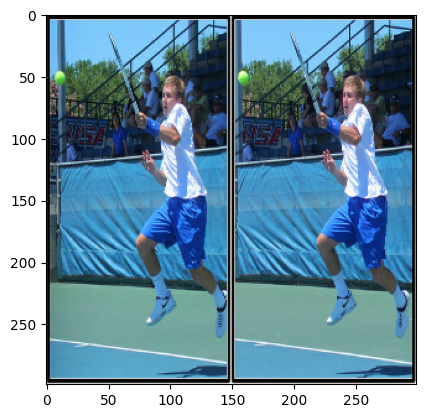

Predicted Caption:  người đàn ông áo trắng đang chơi tennis trên sân


In [61]:
generate_caption(sample_img='/content/dataset/test/images/000000049120.jpg')